# Importy

In [ ]:
!pip install -U datasets
!pip install torch
!pip install transformers
!pip install numpy
!pip install matplotlib
!pip install torchmetrics
!pip install tqdm
!pip install -U scikit-learn
!pip install seaborn
!pip install colorama
!pip install -U bitsandbytes
!pip install accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 14.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pla

In [ ]:
from datasets import load_dataset
import torch
import torch.nn as nn
import numpy as np
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments, DistilBertTokenizerFast
from transformers import AutoTokenizer, AutoModelForCausalLM, DataCollatorForLanguageModeling, BitsAndBytesConfig
from matplotlib import pyplot as plt
import torchmetrics
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.manifold import TSNE
from colorama import Fore
from transformers import BatchEncoding
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Zbiór danych

In [ ]:
dataset = load_dataset("ErfanMoosaviMonazzah/fake-news-detection-dataset-English")

def combine_fields(example):
    example['text'] = example['title'] + " " + example['text']
    return example

dataset = dataset.map(combine_fields)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/487 [00:00<?, ?B/s]

train.tsv:   0%|          | 0.00/78.4M [00:00<?, ?B/s]

validation.tsv:   0%|          | 0.00/15.5M [00:00<?, ?B/s]

test.tsv:   0%|          | 0.00/22.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/30000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/8267 [00:00<?, ? examples/s]

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8267 [00:00<?, ? examples/s]

In [ ]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'title', 'text', 'subject', 'date', 'label'],
        num_rows: 30000
    })
    validation: Dataset({
        features: ['Unnamed: 0', 'title', 'text', 'subject', 'date', 'label'],
        num_rows: 6000
    })
    test: Dataset({
        features: ['Unnamed: 0', 'title', 'text', 'subject', 'date', 'label'],
        num_rows: 8267
    })
})


In [ ]:
print(dataset['train'][1])

{'Unnamed: 0': 16043, 'title': 'YOU WON’T BELIEVE HIS PUNISHMENT! HISPANIC STORE OWNER Swindles Tax Payers Out Of $1,116,924.27 In Latest Food Stamp Scam', 'text': 'YOU WON’T BELIEVE HIS PUNISHMENT! HISPANIC STORE OWNER Swindles Tax Payers Out Of $1,116,924.27 In Latest Food Stamp Scam How did this man come to OWN this store? There is no information on much about this fraudster except that he stole from Americans and is getting just a slap on the wrist. It s no wonder these people are repeat offenders!A hispanic store owner testified in court through a Spanish translator (Why no English?) that he swindled the American tax payers out of millions via food stamp fraud. Eduardo Leonardo plead guilty to stealing from the USDA by illegally exchanging over a million dollars of food stamp benefits for cash for over two years. I stole from the USDA and the Food and Nutrition Service,  Eduardo Leonardo said slowly in Spanish through a translator in Brooklyn Federal Court.  It was an exchange of 

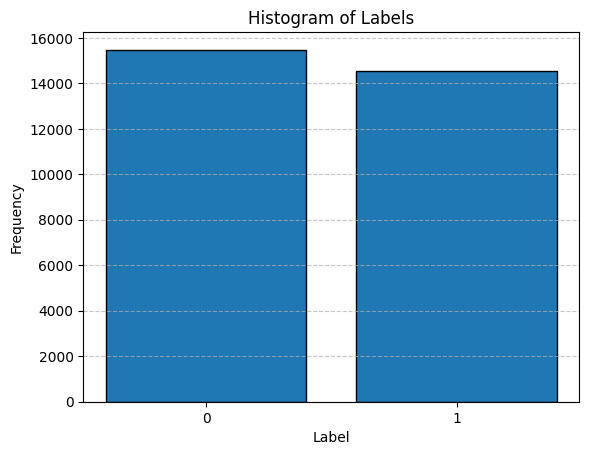

In [ ]:
# Count occurrences of each label in training set
unique_labels, counts = np.unique(dataset['train']['label'], return_counts=True)

# Plot histogram
plt.bar(unique_labels, counts, edgecolor='black')
plt.title('Histogram of Labels')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks(unique_labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Własny klasyfikator

## Tokenizacja

In [ ]:
def get_vectorizer(vocab_size: int = 10000, stop_words: str | None = None):
  vectorizer = TfidfVectorizer(
      max_features=vocab_size,
      lowercase=True,
      analyzer='word',
      ngram_range=(1, 1),
      stop_words=stop_words
  )
  return vectorizer

def make_dataset(sparse_features, labels):
    dense_features = sparse_features.astype(np.float32).todense()
    dataset = torch.utils.data.TensorDataset(
        torch.from_numpy(dense_features),
        torch.tensor(labels, dtype=torch.int64)
    )
    return dataset

In [ ]:
vocab_size = 10_000
vectorizer = get_vectorizer(vocab_size = vocab_size, stop_words="english")

train_tfidf_features = vectorizer.fit_transform(dataset['train']["text"])

val_tfidf_features = vectorizer.transform(dataset['validation']["text"])
test_tfidf_features = vectorizer.transform(dataset['test']["text"])

datasets = {
    'train': make_dataset(train_tfidf_features, dataset['train']['label']),
    'val': make_dataset(val_tfidf_features, dataset['validation']['label']),
    'test': make_dataset(test_tfidf_features, dataset['test']['label'])
}

In [ ]:
batch_size = 256
dataloaders = {split: torch.utils.data.DataLoader(datasets[split], batch_size=batch_size, shuffle=split=='train', num_workers=0) for split in datasets}

## Model

In [ ]:
class SimpleNet(nn.Module):
    def __init__(self, vocab_size: int, n_classes: int):
        super().__init__()
        self.vocab_size = vocab_size
        self.n_classes = n_classes

        self.feature_extractor = nn.Sequential(
            nn.Linear(self.vocab_size, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU()
        )
        self.dropout = nn.Dropout(0.1)
        self.linear = nn.Linear(16, n_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        features = self.feature_extractor(x)
        features = self.dropout(features)
        logits = self.linear(features)
        return logits

## Trening i ewaluacja

In [ ]:
def train(model: nn.Module, loaders: dict[torch.utils.data.DataLoader], criterion: nn.Module,
          optimizer: torch.optim.Optimizer, lr_scheduler, num_epochs: int, verbose: bool):
    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": []
    }

    metric_loss = torchmetrics.aggregation.MeanMetric().to(device)
    metric_acc = torchmetrics.classification.Accuracy(task="multiclass", num_classes=2).to(device)

    for epoch in range(1, num_epochs + 1):
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            for X_batch, target in loaders[phase]:
                X_batch, target = X_batch.to(device), target.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    logits = model(X_batch)
                    _, preds = torch.max(logits, dim=1)
                    loss = criterion(logits, target)

                    metric_loss(loss)
                    metric_acc(preds, target)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

            acc = metric_acc.compute().item()
            mean_loss = metric_loss.compute().item()

            history[f"{phase}_loss"].append(mean_loss)
            history[f"{phase}_acc"].append(acc)

            current_lr = lr_scheduler.get_last_lr()[0]
            if verbose:
                print(f"(Epoch {epoch}/[{phase}]) Loss: {mean_loss:.3f}   Accuracy: {acc:.3f}   lr: {current_lr}")

            metric_loss.reset()
            metric_acc.reset()

        lr_scheduler.step()

    return history

In [ ]:
def evaluate(classifier, dataloader):
  preds_l = []
  targets_l = []

  classifier.eval()
  for X_batch, target in tqdm(dataloader):
      X_batch, target = X_batch.to(device), target.to(device)

      with torch.inference_mode():
          logits = classifier(X_batch)
          _, preds = torch.max(logits, dim=-1)
          preds_l.extend(preds.cpu().numpy())
          targets_l.extend(target.cpu().numpy())

  preds = np.array(preds_l)
  targets = np.array(targets_l)
  labels = ['0', '1']
  report = classification_report(targets, preds, target_names = labels, output_dict=False)
  return report, targets, preds, labels

## Uruchomienie

In [ ]:
classifier = SimpleNet(vocab_size, n_classes=2)
classifier.to(device)

num_epochs = 20
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(classifier.parameters(), lr=1e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-5)

In [ ]:
history = train(classifier, dataloaders, criterion, optimizer, lr_scheduler, num_epochs, True)

(Epoch 1/[train]) Loss: 0.680   Accuracy: 0.573   lr: 0.0001
(Epoch 1/[val]) Loss: 0.657   Accuracy: 0.812   lr: 0.0001
(Epoch 2/[train]) Loss: 0.621   Accuracy: 0.881   lr: 9.94459753267812e-05
(Epoch 2/[val]) Loss: 0.579   Accuracy: 0.925   lr: 9.94459753267812e-05
(Epoch 3/[train]) Loss: 0.524   Accuracy: 0.939   lr: 9.779754323328192e-05
(Epoch 3/[val]) Loss: 0.469   Accuracy: 0.943   lr: 9.779754323328192e-05
(Epoch 4/[train]) Loss: 0.407   Accuracy: 0.951   lr: 9.509529358847657e-05
(Epoch 4/[val]) Loss: 0.355   Accuracy: 0.951   lr: 9.509529358847657e-05
(Epoch 5/[train]) Loss: 0.306   Accuracy: 0.958   lr: 9.140576474687265e-05
(Epoch 5/[val]) Loss: 0.269   Accuracy: 0.955   lr: 9.140576474687265e-05
(Epoch 6/[train]) Loss: 0.235   Accuracy: 0.963   lr: 8.681980515339465e-05
(Epoch 6/[val]) Loss: 0.211   Accuracy: 0.960   lr: 8.681980515339465e-05
(Epoch 7/[train]) Loss: 0.186   Accuracy: 0.967   lr: 8.145033635316131e-05
(Epoch 7/[val]) Loss: 0.174   Accuracy: 0.964   lr: 8.14

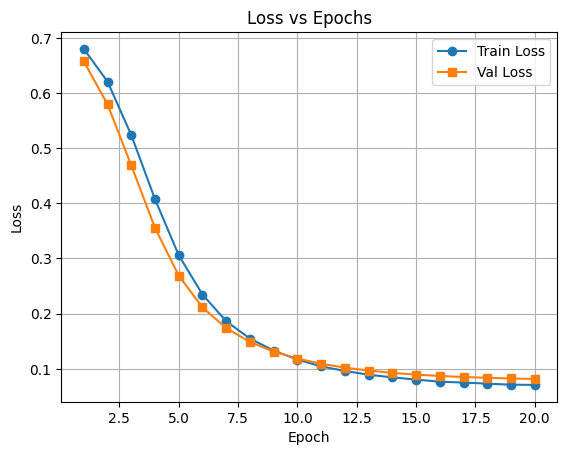

In [ ]:
epochs = range(1, len(history['train_loss']) + 1)

# Wykres Loss
plt.figure()
plt.plot(epochs, history['train_loss'], label='Train Loss', marker='o')
plt.plot(epochs, history['val_loss'], label='Val Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.grid(True)
plt.savefig("loss_plot.png")
plt.show()

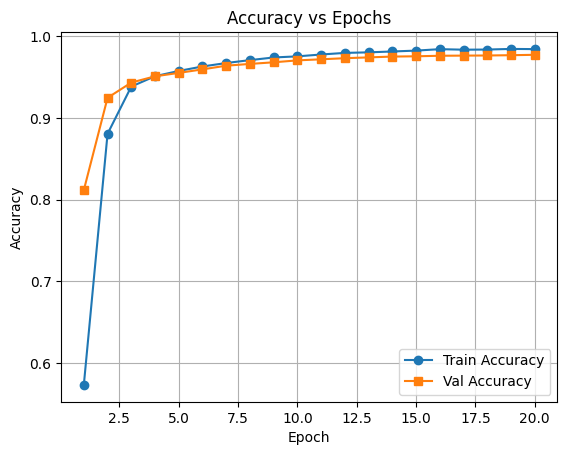

In [ ]:
# Wykres Accuracy
plt.figure()
plt.plot(epochs, history['train_acc'], label='Train Accuracy', marker='o')
plt.plot(epochs, history['val_acc'], label='Val Accuracy', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.grid(True)
plt.savefig("accuracy_plot.png")
plt.show()

In [ ]:
torch.save(classifier.state_dict(), "simplenet_weights.pth")

In [ ]:
# model = SimpleNet(vocab_size=10000, n_classes=2)
# model.load_state_dict(torch.load("simplenet_weights.pth"))

In [ ]:
report, targets, preds, labels = evaluate(classifier, dataloaders['test'])

100%|██████████| 33/33 [00:00<00:00, 129.27it/s]


In [ ]:
print(report)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4284
           1       0.97      0.98      0.98      3983

    accuracy                           0.98      8267
   macro avg       0.98      0.98      0.98      8267
weighted avg       0.98      0.98      0.98      8267



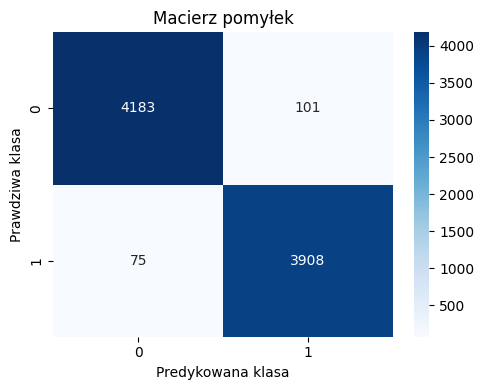

In [ ]:
cm = confusion_matrix(targets, preds)

# Create a heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Macierz pomyłek')
plt.xlabel('Predykowana klasa')
plt.ylabel('Prawdziwa klasa')
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()

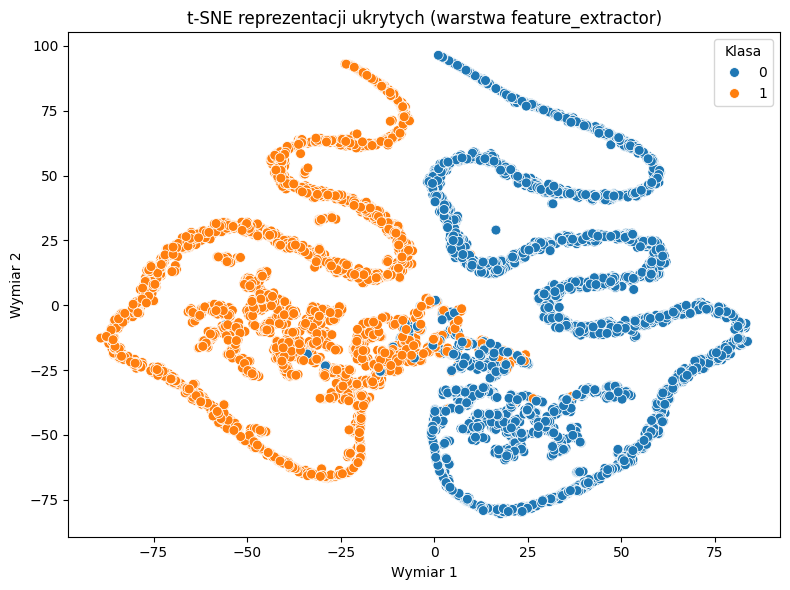

In [ ]:
classifier.eval()
all_features = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in dataloaders['test']:
        X_batch = X_batch.to(device)

        features = classifier.feature_extractor(X_batch)
        all_features.append(features.cpu())
        all_labels.append(y_batch)

X_hidden = torch.cat(all_features, dim=0).numpy()
y_true = torch.cat(all_labels, dim=0).numpy()

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_2d = tsne.fit_transform(X_hidden)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=y_true, palette="tab10", s=50)
plt.title("t-SNE reprezentacji ukrytych (warstwa feature_extractor)")
plt.xlabel("Wymiar 1")
plt.ylabel("Wymiar 2")
plt.legend(title="Klasa")
plt.tight_layout()
plt.savefig("tsne_plot.png")
plt.show()

# Klasyfikator probabilistyczny - DistilBERT base model (uncased)

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=512)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8267 [00:00<?, ? examples/s]

In [ ]:
print(tokenized_datasets['test'][1])

{'Unnamed: 0': 7467, 'title': 'Trump victory may create new tension between U.S. and Islam: Indonesia clerical body', 'text': 'Trump victory may create new tension between U.S. and Islam: Indonesia clerical body Donald Trump’s U.S. election victory may create fresh tension between the United States and the Islamic world, an official at Indonesia’s top Muslim clerical body said on Wednesday. Trump, who once proposed a ban on Muslims entering the United States, stunned the world by defeating heavily favored Hillary Clinton in the presidential race, ending eight years of Democratic rule. Trump had made “negative, cynical” comments about Muslims in the past, Din Syamsuddin, a senior official at the Indonesian Ulema Council (MUI), told reporters in Jakarta. “He had forgotten that many Americans are immigrants.” Indonesia has the world’s largest Muslim population.', 'subject': 'politicsNews', 'date': 'November 9, 2016 ', 'label': 1, 'input_ids': [101, 8398, 3377, 2089, 3443, 2047, 6980, 2090

In [ ]:
tokenized_datasets = tokenized_datasets.map(lambda x: {
    'input_ids': x['input_ids'],
    'attention_mask': x['attention_mask'],
    'labels': x['label']
}, remove_columns=tokenized_datasets['train'].column_names)

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8267 [00:00<?, ? examples/s]

In [ ]:
print(tokenized_datasets['train'][1])

{'input_ids': [101, 2017, 2180, 1521, 1056, 2903, 2010, 7750, 999, 6696, 3573, 3954, 25430, 22254, 4244, 4171, 3477, 2545, 2041, 1997, 1002, 1015, 1010, 12904, 1010, 6227, 2549, 1012, 2676, 1999, 6745, 2833, 11359, 8040, 3286, 2129, 2106, 2023, 2158, 2272, 2000, 2219, 2023, 3573, 1029, 2045, 2003, 2053, 2592, 2006, 2172, 2055, 2023, 9861, 6238, 3272, 2008, 2002, 10312, 2013, 4841, 1998, 2003, 2893, 2074, 1037, 14308, 2006, 1996, 7223, 1012, 2009, 1055, 2053, 4687, 2122, 2111, 2024, 9377, 19591, 999, 1037, 6696, 3573, 3954, 14914, 1999, 2457, 2083, 1037, 3009, 11403, 1006, 2339, 2053, 2394, 1029, 1007, 2008, 2002, 25430, 22254, 3709, 1996, 2137, 4171, 3477, 2545, 2041, 1997, 8817, 3081, 2833, 11359, 9861, 1012, 14846, 14720, 25803, 5905, 2000, 11065, 2013, 1996, 13751, 2050, 2011, 17800, 25620, 2058, 1037, 2454, 6363, 1997, 2833, 11359, 6666, 2005, 5356, 2005, 2058, 2048, 2086, 1012, 1045, 10312, 2013, 1996, 13751, 2050, 1998, 1996, 2833, 1998, 14266, 2326, 1010, 14846, 14720, 2056, 325

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    weight_decay=0.01,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    tokenizer=tokenizer,
)

trainer.train()

<ipython-input-184-9e7d8dfffed2>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.040200,0.003452
2,0.003500,0.002386


TrainOutput(global_step=1876, training_loss=0.013724871821749186, metrics={'train_runtime': 3071.2671, 'train_samples_per_second': 19.536, 'train_steps_per_second': 0.611, 'total_flos': 7948043919360000.0, 'train_loss': 0.013724871821749186, 'epoch': 2.0})

In [ ]:
model.save_pretrained("./distilbert-saved-model")
tokenizer.save_pretrained("./distilbert-saved-model")

('./distilbert-saved-model/tokenizer_config.json',
 './distilbert-saved-model/special_tokens_map.json',
 './distilbert-saved-model/vocab.txt',
 './distilbert-saved-model/added_tokens.json',
 './distilbert-saved-model/tokenizer.json')

In [ ]:
# model_path = "./distilbert-saved-model"

# tokenizer = DistilBertTokenizerFast.from_pretrained(model_path)
# model = DistilBertForSequenceClassification.from_pretrained(model_path)

In [ ]:
predictions = trainer.predict(tokenized_datasets['test'])
logits = predictions.predictions
y_pred = np.argmax(logits, axis=1)
y_true = predictions.label_ids

labels = ['0', '1']
report = classification_report(y_true, y_pred, target_names = labels, output_dict=False)

In [ ]:
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4284
           1       1.00      1.00      1.00      3983

    accuracy                           1.00      8267
   macro avg       1.00      1.00      1.00      8267
weighted avg       1.00      1.00      1.00      8267



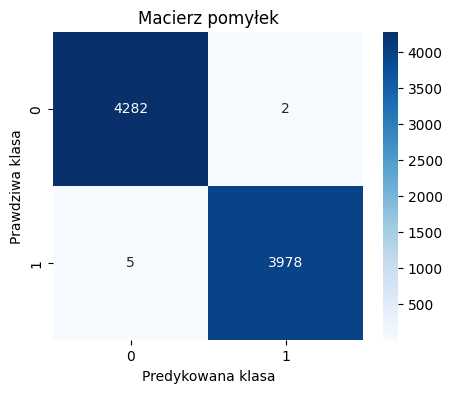

In [ ]:
cm = confusion_matrix(y_true, y_pred)

# Create a heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Macierz pomyłek')
plt.xlabel('Predykowana klasa')
plt.ylabel('Prawdziwa klasa')
plt.savefig("distilbert-confusion_matrix.png")
plt.show()

100%|██████████| 259/259 [01:49<00:00,  2.36it/s]


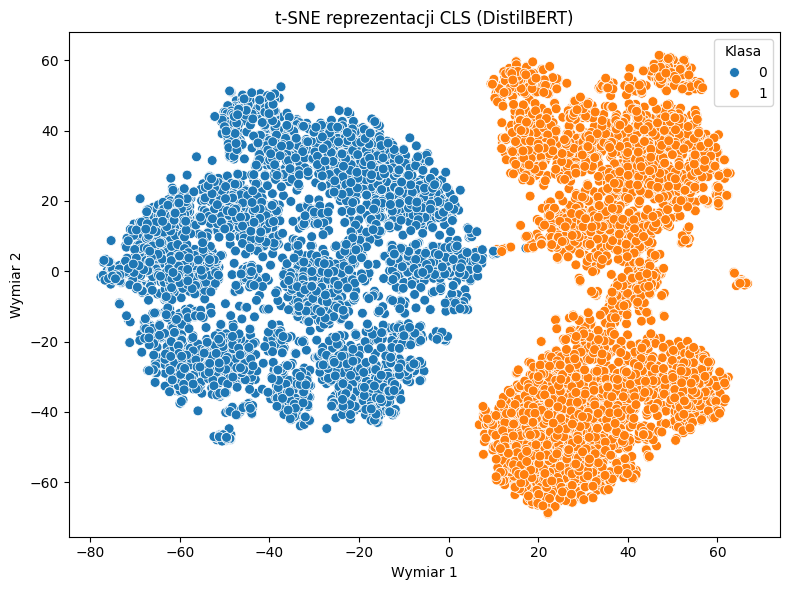

In [ ]:
tokenized_datasets.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_loader = torch.utils.data.DataLoader(tokenized_datasets['test'], batch_size=32)

features = []
labels = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels.extend(batch['labels'].tolist())

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)

        cls_embeddings = outputs.hidden_states[-1][:, 0, :]
        features.append(cls_embeddings.cpu())

features = torch.cat(features, dim=0).numpy()
labels = np.array(labels)

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
features_2d = tsne.fit_transform(features)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=features_2d[:, 0], y=features_2d[:, 1], hue=y_true, palette="tab10", s=50)
plt.title("t-SNE reprezentacji CLS (DistilBERT)")
plt.xlabel("Wymiar 1")
plt.ylabel("Wymiar 2")
plt.legend(title="Klasa")
plt.tight_layout()
plt.savefig("distilbert-tsne_plot.png")
plt.show()

# Model generatywny - Phi-4 mini instruct

In [ ]:
base_model_id = "microsoft/phi-4-mini-instruct"

tokenizer = AutoTokenizer.from_pretrained(base_model_id, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token  # lub tokenizer.pad_token = tokenizer.unk_token jeśli pad_token nie istnieje

q_config = BitsAndBytesConfig(load_in_8bit=True)

model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    quantization_config=q_config,
    torch_dtype=torch.float16,
    trust_remote_code=True,
    low_cpu_mem_usage=True
)

tokenizer_config.json:   0%|          | 0.00/2.93k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/3.91M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/15.5M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/249 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/587 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.50k [00:00<?, ?B/s]

configuration_phi3.py:   0%|          | 0.00/10.9k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/phi-4-mini-instruct:
- configuration_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi3.py:   0%|          | 0.00/54.3k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/phi-4-mini-instruct:
- modeling_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.77G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

In [ ]:
print(model)

Phi3ForCausalLM(
  (model): Phi3Model(
    (embed_tokens): Embedding(200064, 3072, padding_idx=199999)
    (layers): ModuleList(
      (0-31): 32 x Phi3DecoderLayer(
        (self_attn): Phi3Attention(
          (o_proj): Linear8bitLt(in_features=3072, out_features=3072, bias=False)
          (qkv_proj): Linear8bitLt(in_features=3072, out_features=5120, bias=False)
        )
        (mlp): Phi3MLP(
          (gate_up_proj): Linear8bitLt(in_features=3072, out_features=16384, bias=False)
          (down_proj): Linear8bitLt(in_features=8192, out_features=3072, bias=False)
          (activation_fn): SiLU()
        )
        (input_layernorm): Phi3RMSNorm((3072,), eps=1e-05)
        (post_attention_layernorm): Phi3RMSNorm((3072,), eps=1e-05)
        (resid_attn_dropout): Dropout(p=0.0, inplace=False)
        (resid_mlp_dropout): Dropout(p=0.0, inplace=False)
      )
    )
    (norm): Phi3RMSNorm((3072,), eps=1e-05)
    (rotary_emb): Phi3RotaryEmbedding()
  )
  (lm_head): Linear(in_features=

In [ ]:
def generate_text(model: nn.Module, model_input: BatchEncoding, max_new_tokens: int = 100,
                  return_full_text: bool = False) -> str:
  model.eval()
  with torch.no_grad():
    generated_tokens = model.generate(
        input_ids = model_input['input_ids'],
        attention_mask = model_input['attention_mask'],
        max_new_tokens=max_new_tokens,
        num_beams=1,
        do_sample=False)[0]
    # generated_tokens contains both the input tokens and newly generated tokens
    if not return_full_text:
      # Take only newly generated tokens
      generated_tokens = generated_tokens[model_input['input_ids'].shape[1]:]
    return tokenizer.decode(generated_tokens, skip_special_tokens=True)


def generate_and_print_text(model: nn.Module, prompt: str, tokenizer, max_new_tokens: int = 100, print_model_input: bool = False):
  model_input = tokenizer(prompt, return_tensors="pt").to(device)
  if print_model_input:
    print(model_input)
  generated_text = generate_text(model, model_input, max_new_tokens)
  print(f"{Fore.BLACK}{prompt}", end="")
  print(f"{Fore.BLUE}{generated_text}")

In [ ]:
def tokenize_with_padding(prompt, max_length: int):
    result = tokenizer(prompt, truncation=True, max_length=max_length, padding="max_length")
    result["labels"] = result["input_ids"].copy()
    return result

## Zero-shot prompting

In [ ]:
def test_prompt_with_instruction(data_point) -> str:
    prompt =f"""Is this fake news? Answer yes or no:
### Input article:
{data_point["text"]}
### Answer:
"""
    return prompt

In [ ]:
data_point = dataset['train'][1]
print(data_point)

{'Unnamed: 0': 16043, 'title': 'YOU WON’T BELIEVE HIS PUNISHMENT! HISPANIC STORE OWNER Swindles Tax Payers Out Of $1,116,924.27 In Latest Food Stamp Scam', 'text': 'YOU WON’T BELIEVE HIS PUNISHMENT! HISPANIC STORE OWNER Swindles Tax Payers Out Of $1,116,924.27 In Latest Food Stamp Scam How did this man come to OWN this store? There is no information on much about this fraudster except that he stole from Americans and is getting just a slap on the wrist. It s no wonder these people are repeat offenders!A hispanic store owner testified in court through a Spanish translator (Why no English?) that he swindled the American tax payers out of millions via food stamp fraud. Eduardo Leonardo plead guilty to stealing from the USDA by illegally exchanging over a million dollars of food stamp benefits for cash for over two years. I stole from the USDA and the Food and Nutrition Service,  Eduardo Leonardo said slowly in Spanish through a translator in Brooklyn Federal Court.  It was an exchange of 

In [ ]:
print("\nPrompt:")
prompt = test_prompt_with_instruction(data_point)
print(prompt)


Prompt:
Is this fake news? Answer yes or no:
### Input article:
YOU WON’T BELIEVE HIS PUNISHMENT! HISPANIC STORE OWNER Swindles Tax Payers Out Of $1,116,924.27 In Latest Food Stamp Scam How did this man come to OWN this store? There is no information on much about this fraudster except that he stole from Americans and is getting just a slap on the wrist. It s no wonder these people are repeat offenders!A hispanic store owner testified in court through a Spanish translator (Why no English?) that he swindled the American tax payers out of millions via food stamp fraud. Eduardo Leonardo plead guilty to stealing from the USDA by illegally exchanging over a million dollars of food stamp benefits for cash for over two years. I stole from the USDA and the Food and Nutrition Service,  Eduardo Leonardo said slowly in Spanish through a translator in Brooklyn Federal Court.  It was an exchange of benefits for cash. Leonardo, 57,  admitted to committing  food stamp  fraud between Oct. 2015 and Ma

In [ ]:
generate_and_print_text(model, prompt, tokenizer, max_new_tokens=5)

Is this fake news? Answer yes or no:
### Input article:
YOU WON’T BELIEVE HIS PUNISHMENT! HISPANIC STORE OWNER Swindles Tax Payers Out Of $1,116,924.27 In Latest Food Stamp Scam How did this man come to OWN this store? There is no information on much about this fraudster except that he stole from Americans and is getting just a slap on the wrist. It s no wonder these people are repeat offenders!A hispanic store owner testified in court through a Spanish translator (Why no English?) that he swindled the American tax payers out of millions via food stamp fraud. Eduardo Leonardo plead guilty to stealing from the USDA by illegally exchanging over a million dollars of food stamp benefits for cash for over two years. I stole from the USDA and the Food and Nutrition Service,  Eduardo Leonardo said slowly in Spanish through a translator in Brooklyn Federal Court.  It was an exchange of benefits for cash. Leonardo, 57,  admitted to committing  food stamp  fraud between Oct. 2015 and March 2017 

In [ ]:
def predict_label_from_text(output_text):
    words = output_text.strip().lower().split()
    if not words:
        return -1
    first_word = words[0]
    if "yes" in first_word:
        return 0
    elif "no" in first_word:
        return 1
    else:
        return -1

def generate_predictions_full(model, tokenizer, dataset, prompt_fn, max_new_tokens=5):
  preds = []
  labels = []
  counter = 0
  for example in tqdm(dataset, desc="Generating predictions"):
    if counter == 500: # ograniczenie do 500 elementów
      break
    label = example["label"]
    prompt = prompt_fn(example)
    model_input = tokenizer(prompt, return_tensors="pt").to(device)
    generated_text = generate_text(model, model_input, max_new_tokens)
    pred = predict_label_from_text(generated_text)

    preds.append(pred)
    labels.append(label)
    counter += 1
  return preds, labels

In [ ]:
preds, labels = generate_predictions_full(model, tokenizer, dataset['test'], test_prompt_with_instruction)

Generating predictions:   6%|▌         | 500/8267 [04:42<1:13:06,  1.77it/s]


In [ ]:
print('Ilość niepoprawnie wygenerowanych odpowiedzi modelu: ', preds.count(-1))

Ilość niepoprawnie wygenerowanych odpowiedzi modelu:  0


In [ ]:
import pickle

with open("predictions.pkl", "wb") as f:
    pickle.dump((labels, preds), f)

In [ ]:
filtered_preds_labels = [(p, l) for p, l in zip(preds, labels) if p != -1]
filtered_preds, filtered_labels = zip(*filtered_preds_labels)
filtered_preds = list(filtered_preds)
filtered_labels = list(filtered_labels)

In [ ]:
report = classification_report(filtered_labels, filtered_preds, target_names = ['0', '1'], output_dict=False)

In [ ]:
print(report)

              precision    recall  f1-score   support

           0       0.54      0.86      0.66       250
           1       0.65      0.26      0.38       250

    accuracy                           0.56       500
   macro avg       0.59      0.56      0.52       500
weighted avg       0.59      0.56      0.52       500



## Few-shot learning

In [ ]:
label_map = {0: 'yes', 1: 'no'}

In [ ]:
def train_prompt_with_instruction(data_point) -> str:
    prompt =f"""Is this fake news? Answer yes or no:
### Input article:
{data_point["text"]}
### Answer:
{label_map[data_point['label']]}
"""
    return prompt

In [ ]:
example = dataset['test'][1]
print(example['text'])
print('Label: ', example['label'])

Trump victory may create new tension between U.S. and Islam: Indonesia clerical body Donald Trump’s U.S. election victory may create fresh tension between the United States and the Islamic world, an official at Indonesia’s top Muslim clerical body said on Wednesday. Trump, who once proposed a ban on Muslims entering the United States, stunned the world by defeating heavily favored Hillary Clinton in the presidential race, ending eight years of Democratic rule. Trump had made “negative, cynical” comments about Muslims in the past, Din Syamsuddin, a senior official at the Indonesian Ulema Council (MUI), told reporters in Jakarta. “He had forgotten that many Americans are immigrants.” Indonesia has the world’s largest Muslim population.
Label:  1


In [ ]:
print(train_prompt_with_instruction(example))

Is this fake news? Answer yes or no:
### Input article:
Trump victory may create new tension between U.S. and Islam: Indonesia clerical body Donald Trump’s U.S. election victory may create fresh tension between the United States and the Islamic world, an official at Indonesia’s top Muslim clerical body said on Wednesday. Trump, who once proposed a ban on Muslims entering the United States, stunned the world by defeating heavily favored Hillary Clinton in the presidential race, ending eight years of Democratic rule. Trump had made “negative, cynical” comments about Muslims in the past, Din Syamsuddin, a senior official at the Indonesian Ulema Council (MUI), told reporters in Jakarta. “He had forgotten that many Americans are immigrants.” Indonesia has the world’s largest Muslim population.
### Answer:
no



In [ ]:
import random

random.seed(123)

def create_demonstration_prompt(dataset, n_examples: int) -> str:
    prompt = ""
    for _ in range(n_examples):
        example = random.choice(dataset)
        prompt += train_prompt_with_instruction(example)
        prompt += "\n"
    return prompt

In [ ]:
s = create_demonstration_prompt(dataset['train'], 4)
s += test_prompt_with_instruction(dataset['test'][1])

generate_and_print_text(model, s, tokenizer, max_new_tokens=5)

Is this fake news? Answer yes or no:
### Input article:
LOL! CNN Tells Viewers “IT’S ILLEGAL” To Read Wikileaks Emails…So They’ll Tell You What’s In Them [VIDEO] Wow! CNN host Chris Cuomo tells viewers it s ILLEGAL to read the Wikileaks emails, but if you watch them, they will tell you what they say. And no he s not kidding! https://twitter.com/Always_Trump/status/787673496537092096Sounds pretty legit Here s leftist CNN host telling his viewers,  We couldn t help Hillary anymore than we have.
### Answer:
yes

Is this fake news? Answer yes or no:
### Input article:
IS GOP ESTABLISHMENT Responsible For Pro-Amnesty Spanish Version Of Nikki Haley’s GOP Response To Obama’s SOTU? [Video] This is a very big development. We all knew the GOP establishment has been pandering to pro-amnesty corporations and the Chamber of Commerce, but this is a new low, even for the GOP establishment There is a bigger controversy about to break wide-open that s potentially far more significant than Paul Ryan and

## Dostrajanie metodą LoRA

In [ ]:
import copy
from peft import LoraConfig, get_peft_model, TaskType


config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["qkv_proj", "gate_up_proj", "down_proj"],
    bias="none",
    lora_dropout=0.05,
    task_type=TaskType.CAUSAL_LM
)

peft_model = get_peft_model(copy.deepcopy(model), config)

In [ ]:
peft_model.print_trainable_parameters()

trainable params: 19,922,944 || all params: 3,855,944,704 || trainable%: 0.5167


In [ ]:
def generate_and_tokenize_train_prompt_with_padding(data_point):
    max_length = 180
    return tokenize_with_padding(train_prompt_with_instruction(data_point), max_length)

tokenized_train_dataset = dataset['train'].map(generate_and_tokenize_train_prompt_with_padding)
tokenized_val_dataset = dataset['validation'].map(generate_and_tokenize_train_prompt_with_padding)

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

In [ ]:
import transformers
from datetime import datetime

output_dir = "./phi-qlora"

report_to = "none"
# report_to = "wandb"

training_args = transformers.TrainingArguments(
    output_dir=output_dir,
    warmup_steps=3,
    per_device_train_batch_size=6,
    gradient_accumulation_steps=2,
    max_steps=2000,
    learning_rate=5e-5,
    optim="paged_adamw_8bit",
    logging_dir="./logs",
    logging_steps=50,
    eval_strategy="steps",
    eval_steps=500,
    do_eval=True,
    report_to=report_to,
    save_strategy="steps",
    save_steps=100,
)

trainer = transformers.Trainer(
    model=peft_model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=training_args,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

peft_model.config.use_cache = False  # wyłącz cache na czas treningu, żeby uniknąć warningów
trainer.train()
peft_model.config.use_cache = True   # włącz cache z powrotem na potrzeby inferencji


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss,Validation Loss
500,2.744300,2.755750
1000,2.728500,2.731919
1500,2.710500,2.730289
2000,2.681200,2.722811


In [ ]:
peft_model.save_pretrained("./phi4-lora-finetuned")
tokenizer.save_pretrained("./phi4-lora-finetuned")

('./phi4-lora-finetuned/tokenizer_config.json',
 './phi4-lora-finetuned/special_tokens_map.json',
 './phi4-lora-finetuned/chat_template.jinja',
 './phi4-lora-finetuned/vocab.json',
 './phi4-lora-finetuned/merges.txt',
 './phi4-lora-finetuned/added_tokens.json',
 './phi4-lora-finetuned/tokenizer.json')

In [ ]:
peft_model.eval()
with torch.no_grad():
  idx = 1
  print('True label:', dataset['test'][idx]['label'])
  prompt = test_prompt_with_instruction(dataset['test'][idx])
  generate_and_print_text(peft_model, prompt, tokenizer, max_new_tokens=5)

True label: 1
Is this fake news? Answer yes or no:
### Input article:
Trump victory may create new tension between U.S. and Islam: Indonesia clerical body Donald Trump’s U.S. election victory may create fresh tension between the United States and the Islamic world, an official at Indonesia’s top Muslim clerical body said on Wednesday. Trump, who once proposed a ban on Muslims entering the United States, stunned the world by defeating heavily favored Hillary Clinton in the presidential race, ending eight years of Democratic rule. Trump had made “negative, cynical” comments about Muslims in the past, Din Syamsuddin, a senior official at the Indonesian Ulema Council (MUI), told reporters in Jakarta. “He had forgotten that many Americans are immigrants.” Indonesia has the world’s largest Muslim population.
### Answer:
no
### Input article


In [ ]:
preds, labels = generate_predictions_full(peft_model, tokenizer, dataset['test'], test_prompt_with_instruction)

Generating predictions:   6%|▌         | 500/8267 [05:41<1:28:29,  1.46it/s]


In [ ]:
import pickle

with open("predictions_peft.pkl", "wb") as f:
    pickle.dump((labels, preds), f)

In [ ]:
# import pickle

# with open("predictions_peft.pkl", "rb") as f:
#     labels, preds = pickle.load(f)

In [ ]:
print('Ilość niepoprawnie wygenerowanych odpowiedzi modelu: ', preds.count(-1))

Ilość niepoprawnie wygenerowanych odpowiedzi modelu:  0


In [ ]:
filtered_preds_labels = [(p, l) for p, l in zip(preds, labels) if p != -1]
filtered_preds, filtered_labels = zip(*filtered_preds_labels)
filtered_preds = list(filtered_preds)
filtered_labels = list(filtered_labels)

In [ ]:
report = classification_report(filtered_labels, filtered_preds, target_names = ['0', '1'], output_dict=False)

In [ ]:
print(report)

              precision    recall  f1-score   support

           0       0.97      0.90      0.93       250
           1       0.91      0.97      0.94       250

    accuracy                           0.94       500
   macro avg       0.94      0.94      0.94       500
weighted avg       0.94      0.94      0.94       500



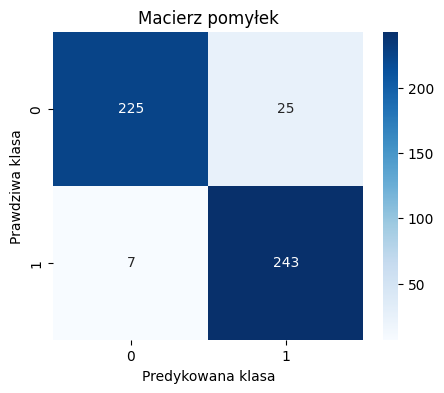

In [ ]:
cm = confusion_matrix(filtered_labels, filtered_preds)

# Create a heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.title('Macierz pomyłek')
plt.xlabel('Predykowana klasa')
plt.ylabel('Prawdziwa klasa')
plt.savefig("phi-confusion_matrix.png")
plt.show()

In [ ]:
def generate_tsne_embeddings(model, tokenizer, dataset, prompt_fn, max_samples=500, max_new_tokens=5, save_path="tsne_phi.png"):
    model.eval()
    tsne_vectors = []
    tsne_labels = []

    with torch.no_grad():
        for i, example in enumerate(tqdm(dataset, desc="TSNE: extracting hidden states")):
            if i >= max_samples:
                break

            prompt = prompt_fn(example)
            label = example["label"]
            inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to(model.device)

            outputs = model(**inputs, output_hidden_states=True)
            hidden_state = outputs.hidden_states[-1]

            representation = hidden_state.mean(dim=1).squeeze().cpu().numpy()

            tsne_vectors.append(representation)
            tsne_labels.append(label)

    tsne_vectors = np.array(tsne_vectors)
    tsne_labels = np.array(tsne_labels)

    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    reduced = tsne.fit_transform(tsne_vectors)

    plt.figure(figsize=(10, 6))
    for label in np.unique(tsne_labels):
        idxs = tsne_labels == label
        plt.scatter(reduced[idxs, 0], reduced[idxs, 1], label=f"Label {label}", alpha=0.6)
    plt.title("t-SNE reprezentacji z modelu generatywnego")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

TSNE: extracting hidden states:   6%|▌         | 500/8267 [01:27<22:33,  5.74it/s]


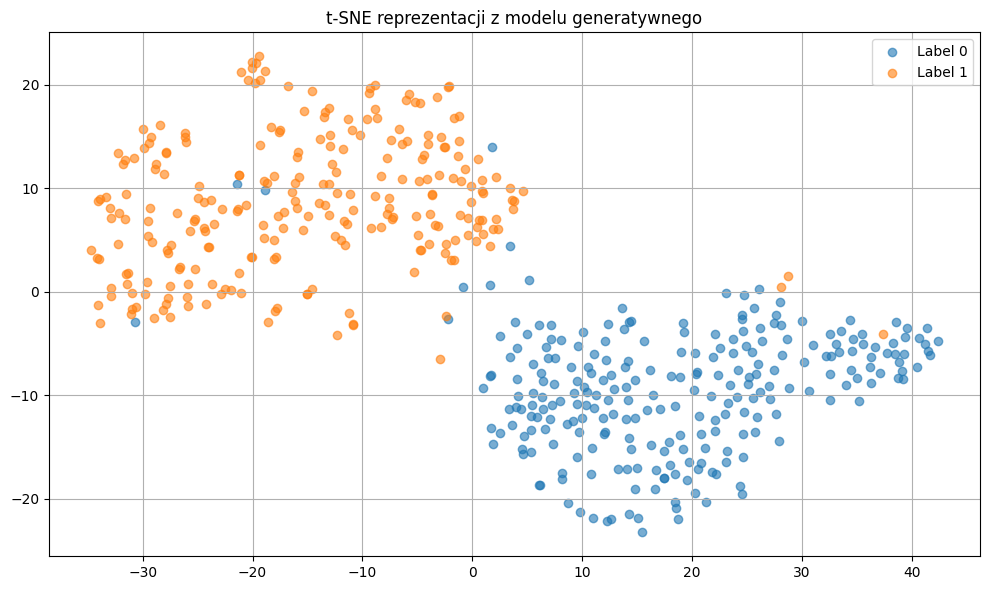

In [ ]:
generate_tsne_embeddings(peft_model, tokenizer, dataset["test"], test_prompt_with_instruction)

In [ ]:
print('INCORRECT PREDICTIONS')
for idx in range(len(preds)):
  if preds[idx] != labels[idx]:
    print('-'*20)
    print('True label: ', labels[idx])
    print('Predicted label: ', preds[idx])
    print(dataset['test'][idx])
    print()

INCORRECT PREDICTIONS
--------------------
True label:  1
Predicted label:  0
{'Unnamed: 0': 276, 'title': 'Democratic Senator Franken to resign: CNN, citing sources', 'text': 'Democratic Senator Franken to resign: CNN, citing sources U.S. Democratic Senator Al Franken will announce his resignation on Thursday, a day after a majority of his Democratic Senate colleagues called for him to step down following a string of sexual misconduct allegations against him, CNN reported on Thursday, citing unnamed sources.', 'subject': 'politicsNews', 'date': 'December 7, 2017 ', 'label': 1}

--------------------
True label:  0
Predicted label:  1
{'Unnamed: 0': 6919, 'title': 'Civil Rights Legend Switches Endorsement And Primary Vote From Sanders To Clinton', 'text': 'Civil Rights Legend Switches Endorsement And Primary Vote From Sanders To Clinton On Tuesday, Tom Hayden, one of leading dirty hippies that drove Republicans (and Democrats) completely insane in the 1960s wrote a lengthy editorial in 